In [17]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data_df = pd.read_csv('../../../data/processed/fully_integrated_data.csv')
data_df.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

In [26]:
driver_stats = data_df.groupby('driverId').agg(
    total_races = ('raceId', 'nunique'),
    wins = ('driverFinalRank', lambda x: (x == 1).sum()),
    podiums = ('driverFinalRank', lambda x: ((x == 1) | (x == 2) | (x == 3)).sum()),
    total_points = ('driverRacePoints', 'sum'),
    first_year = ('season', 'min'),
    last_year = ('season', 'max')
).reset_index()

driver_stats['career_span'] = driver_stats['last_year'] - driver_stats['first_year'] + 1
driver_stats['win_ratio'] = driver_stats['wins'] / driver_stats['total_races']
driver_stats['podium_ratio'] = driver_stats['podiums'] / driver_stats['total_races']
driver_stats.head()

,driverId,total_races,wins,podiums,total_points,first_year,last_year,career_span,win_ratio,podium_ratio
0,1,356,105,202,4820.5,2007,2024,18,0.294944,0.567416
1,2,184,0,13,259.0,2000,2011,12,0.000000,0.070652
2,3,206,23,57,1594.5,2006,2016,11,0.111650,0.276699
3,4,404,32,106,2329.0,2001,2024,24,0.079208,0.262376
4,5,112,1,4,105.0,2007,2013,7,0.008929,0.035714


In [29]:
# Calculate performance metrics
constructor_performance = data_df.groupby('constructorName').agg({
    'raceId': 'count',  # Total races
    'driverFinalRank': lambda x: (x == 1).sum(),  # Wins
    'driverRacePoints': ['sum', 'mean']  # Total and average points
}).reset_index()

# Add derived metrics
constructor_performance.columns = ['constructorName', 'total_races', 'wins', 'total_points', 'avg_points']
constructor_performance['win_ratio'] = constructor_performance['wins'] / constructor_performance['total_races']
constructor_performance['podium_rate'] = data_df.groupby('constructorName').apply(
    lambda x: (x['driverFinalRank'].isin([1, 2, 3])).sum() / len(x)
).values

# Filter for significant participation (min 50 races)
significant_constructors = constructor_performance[constructor_performance['total_races'] >= 50]
constructor_performance.head()

C:\Users\yeshw\AppData\Local\Temp\ipykernel_29984\3818057990.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  constructor_performance['podium_rate'] = data_df.groupby('constructorName').apply(


,constructorName,total_races,wins,total_points,avg_points,win_ratio,podium_rate
0,AFM,7,0,0.0,0.000000,0.00000,0.000000
1,AGS,123,0,2.0,0.016260,0.00000,0.000000
2,ATS,162,0,7.0,0.043210,0.00000,0.000000
3,Adams,2,0,0.0,0.000000,0.00000,0.000000
4,Alfa Romeo,451,11,361.0,0.800443,0.02439,0.062084


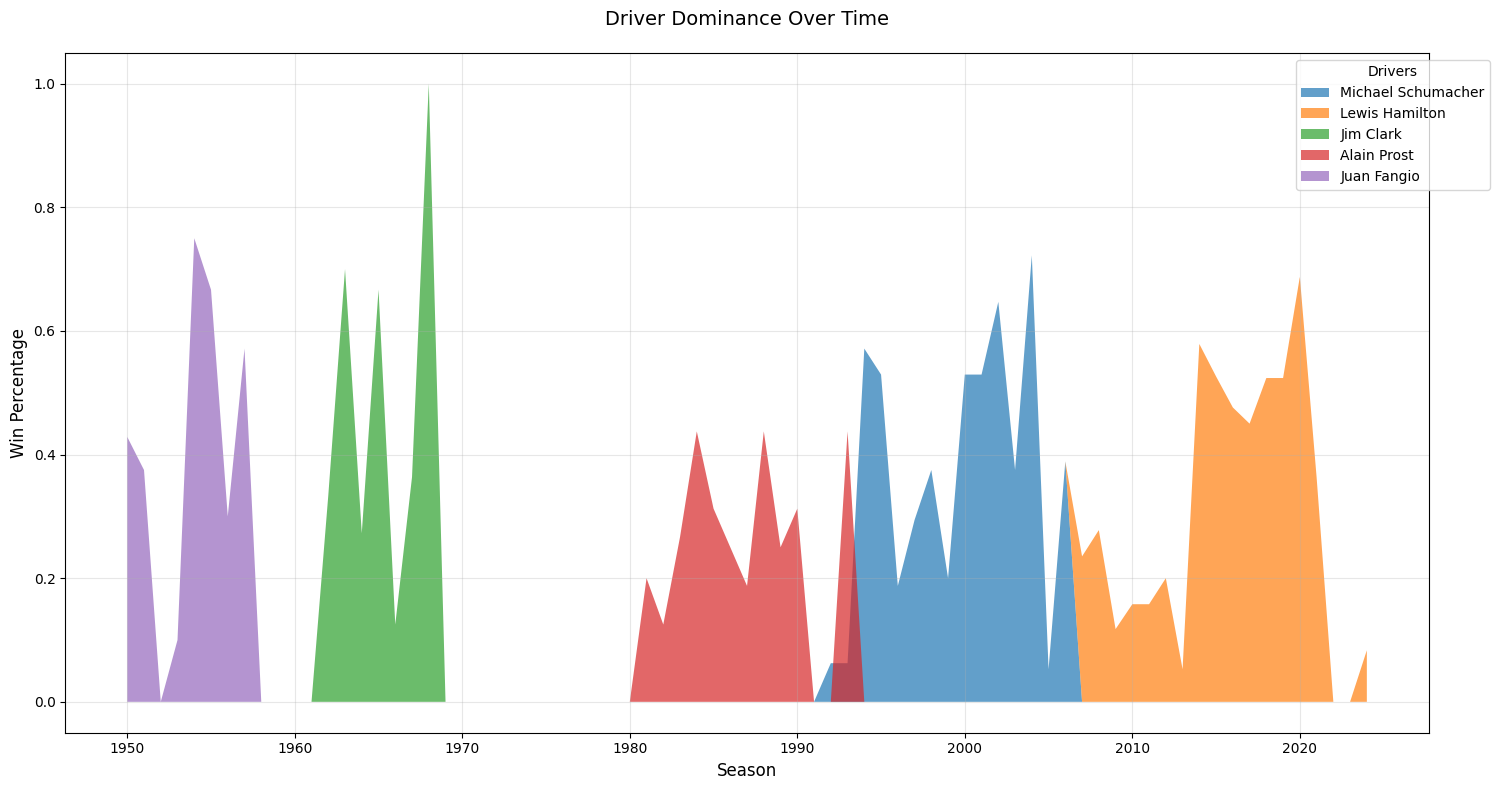


Top 5 Drivers by Win Percentage:
        driverName  raceId  driverFinalRank  win_percentage
       Juan Fangio      58               24           41.38
         Jim Clark      73               25           34.25
    Max Verstappen     209               63           30.14
Michael Schumacher     308               91           29.55
    Lewis Hamilton     356              105           29.49


In [30]:
# Create timeline of driver dominance
plt.figure(figsize=(15, 8))

# Calculate yearly win percentages for drivers
yearly_driver_wins = data_df.pivot_table(
    index='season',
    columns='driverName',
    values='driverFinalRank',
    aggfunc=lambda x: (x == 1).sum() / len(x)
).fillna(0)

# Get top 5 drivers by average win percentage
top_drivers = yearly_driver_wins.mean().nlargest(5).index
data_to_plot = [yearly_driver_wins[driver].values for driver in top_drivers]

# Create stacked area plot
plt.fill_between(yearly_driver_wins.index, data_to_plot[0], 
                 label=top_drivers[0], alpha=0.7)
for i in range(1, len(data_to_plot)):
    plt.fill_between(yearly_driver_wins.index, 
                    data_to_plot[i-1] + data_to_plot[i], 
                    data_to_plot[i-1], 
                    label=top_drivers[i], 
                    alpha=0.7)

# Customize plot
plt.title('Driver Dominance Over Time', fontsize=14, pad=20)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Win Percentage', fontsize=12)
plt.legend(title='Drivers', bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics for top drivers
print("\nTop 5 Drivers by Win Percentage:")
driver_stats = data_df.groupby('driverName').agg({
    'raceId': 'count',
    'driverFinalRank': lambda x: (x == 1).sum(),
}).reset_index()
driver_stats['win_percentage'] = (driver_stats['driverFinalRank'] / driver_stats['raceId'] * 100)
driver_stats = driver_stats[driver_stats['raceId'] >= 50]  # Min 50 races
print(driver_stats.nlargest(5, 'win_percentage')[
    ['driverName', 'raceId', 'driverFinalRank', 'win_percentage']
].round(2).to_string(index=False))

C:\Users\yeshw\AppData\Local\Temp\ipykernel_29984\3470989528.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  driver_performance['podium_rate'] = data_df.groupby('driverName').apply(


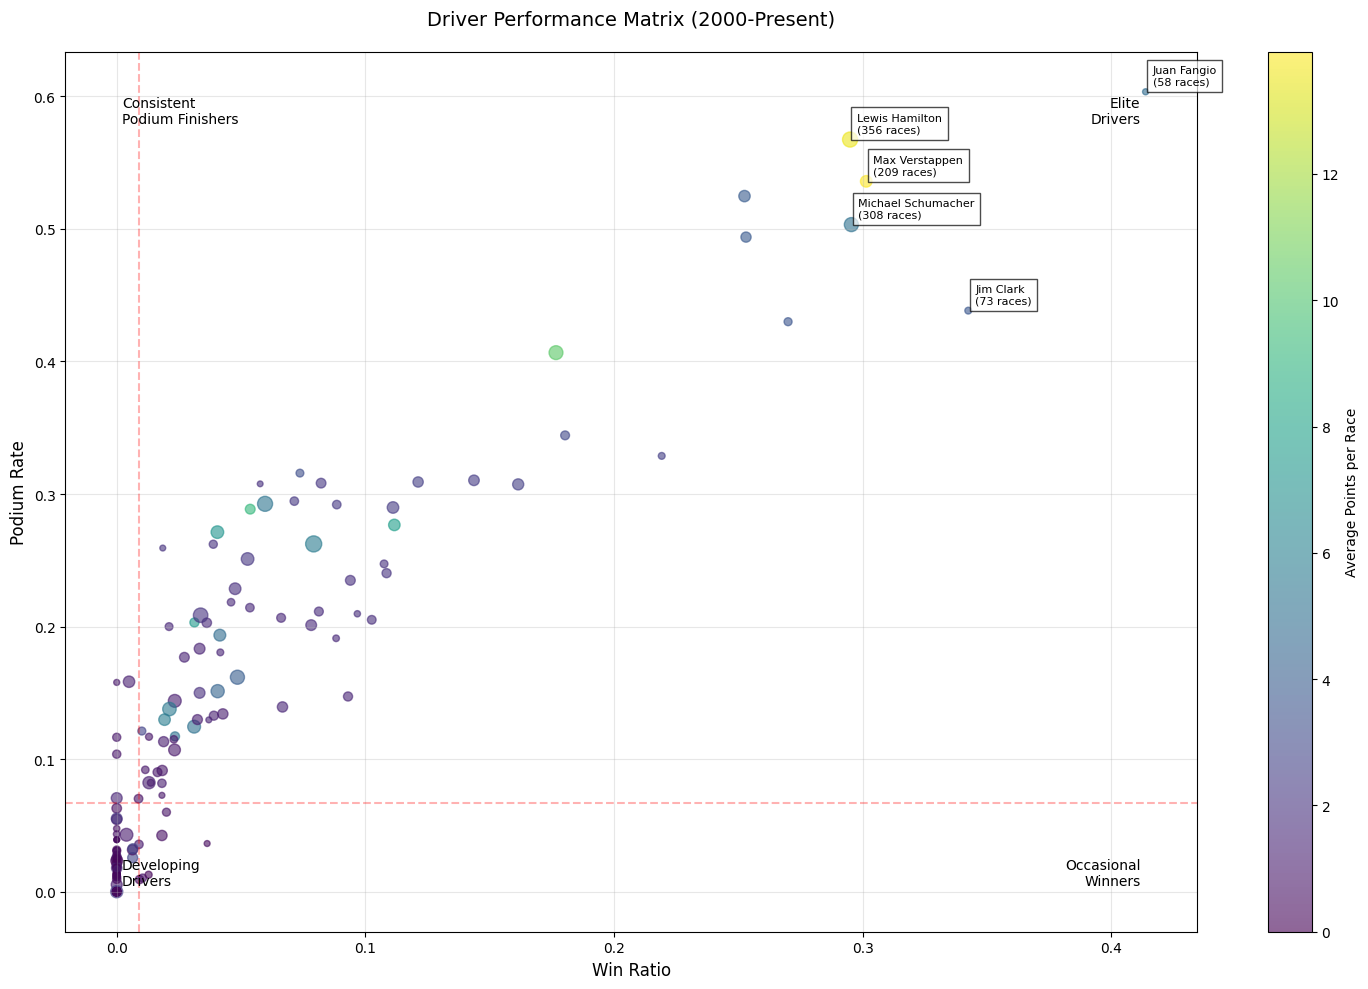


Top 5 Drivers by Win Ratio:
        driverName  raceId  win_ratio  podium_rate  driverRacePoints
       Juan Fangio      58      0.414        0.603             4.813
         Jim Clark      73      0.342        0.438             3.753
    Max Verstappen     209      0.301        0.536            13.935
Michael Schumacher     308      0.295        0.503             5.084
    Lewis Hamilton     356      0.295        0.567            13.541


In [32]:
# Calculate driver performance metrics for matrix
driver_performance = data_df.groupby('driverName').agg({
    'raceId': 'count',  # Total races
    'driverFinalRank': lambda x: (x == 1).sum(),  # Total wins
    'driverRacePoints': 'mean'  # Average points
}).reset_index()

# Calculate win ratio and podium rate
driver_performance['win_ratio'] = driver_performance['driverFinalRank'] / driver_performance['raceId']
driver_performance['podium_rate'] = data_df.groupby('driverName').apply(
    lambda x: sum(x['driverFinalRank'].isin([1, 2, 3])) / len(x)
).values

# Filter for significant participation (min 50 races)
significant_drivers = driver_performance[driver_performance['raceId'] >= 50].copy()

# Create performance visualization
plt.figure(figsize=(15, 10))

# Create scatter plot
scatter = plt.scatter(significant_drivers['win_ratio'], 
                     significant_drivers['podium_rate'],
                     s=significant_drivers['raceId']/3,  # Adjusted size scaling
                     c=significant_drivers['driverRacePoints'],
                     cmap='viridis',
                     alpha=0.6)

# Annotate top performers
top_performers = significant_drivers.nlargest(5, 'win_ratio')
for _, row in top_performers.iterrows():
    plt.annotate(f"{row['driverName']}\n({row['raceId']} races)",
                (row['win_ratio'], row['podium_rate']),
                xytext=(5, 5),
                textcoords='offset points',
                bbox=dict(facecolor='white', alpha=0.7),
                fontsize=8)

# Add reference lines
plt.axhline(y=significant_drivers['podium_rate'].median(), color='r', linestyle='--', alpha=0.3)
plt.axvline(x=significant_drivers['win_ratio'].median(), color='r', linestyle='--', alpha=0.3)

# Customize plot
plt.colorbar(scatter, label='Average Points per Race')
plt.title('Driver Performance Matrix (2000-Present)', fontsize=14, pad=20)
plt.xlabel('Win Ratio', fontsize=12)
plt.ylabel('Podium Rate', fontsize=12)
plt.grid(True, alpha=0.3)

# Add quadrant labels
plt.text(0.95, 0.95, 'Elite\nDrivers', ha='right', va='top', transform=plt.gca().transAxes)
plt.text(0.05, 0.95, 'Consistent\nPodium Finishers', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.05, 0.05, 'Developing\nDrivers', ha='left', va='bottom', transform=plt.gca().transAxes)
plt.text(0.95, 0.05, 'Occasional\nWinners', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Print performance statistics
print("\nTop 5 Drivers by Win Ratio:")
print(top_performers[['driverName', 'raceId', 'win_ratio', 'podium_rate', 'driverRacePoints']]
      .round(3).to_string(index=False))

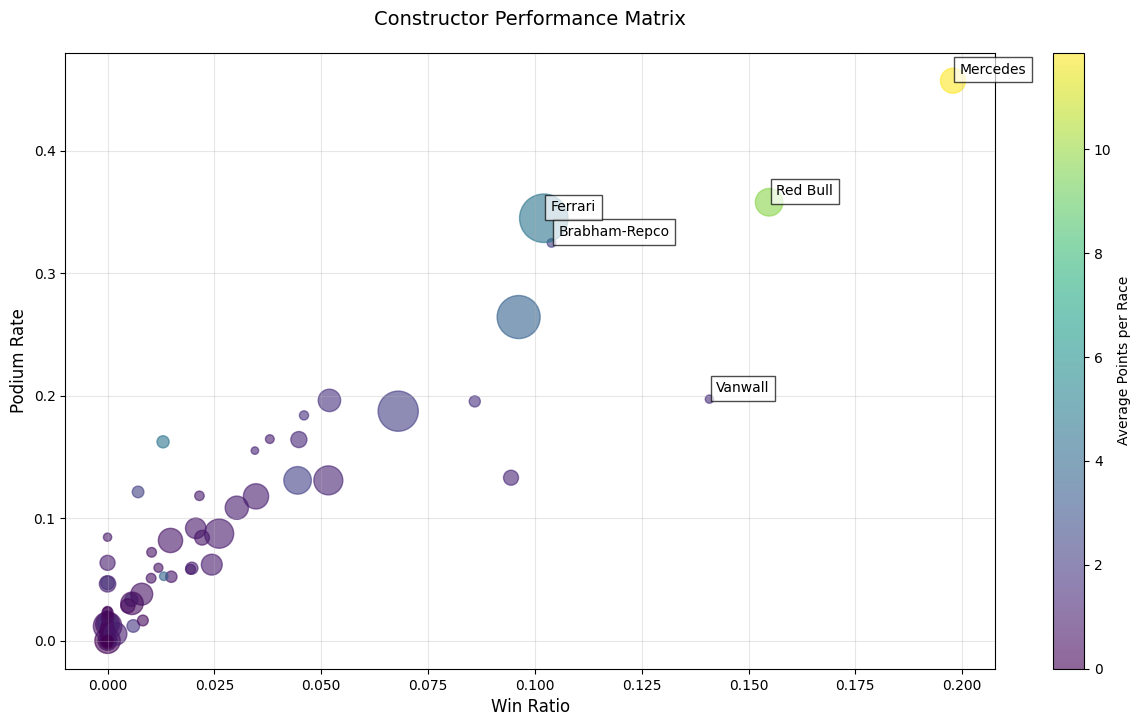

In [21]:
# Create performance visualization
plt.figure(figsize=(15, 8))

# Scatter plot of win ratio vs podium rate
scatter = plt.scatter(significant_constructors['win_ratio'], 
                     significant_constructors['podium_rate'],
                     s=significant_constructors['total_races']/2,
                     c=significant_constructors['avg_points'],
                     cmap='viridis',
                     alpha=0.6)

# Add constructor labels for top performers
top_performers = significant_constructors.nlargest(5, 'win_ratio')
for _, row in top_performers.iterrows():
    plt.annotate(row['constructorName'],
                (row['win_ratio'], row['podium_rate']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7))

plt.colorbar(scatter, label='Average Points per Race')
plt.title('Constructor Performance Matrix', fontsize=14, pad=20)
plt.xlabel('Win Ratio', fontsize=12)
plt.ylabel('Podium Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

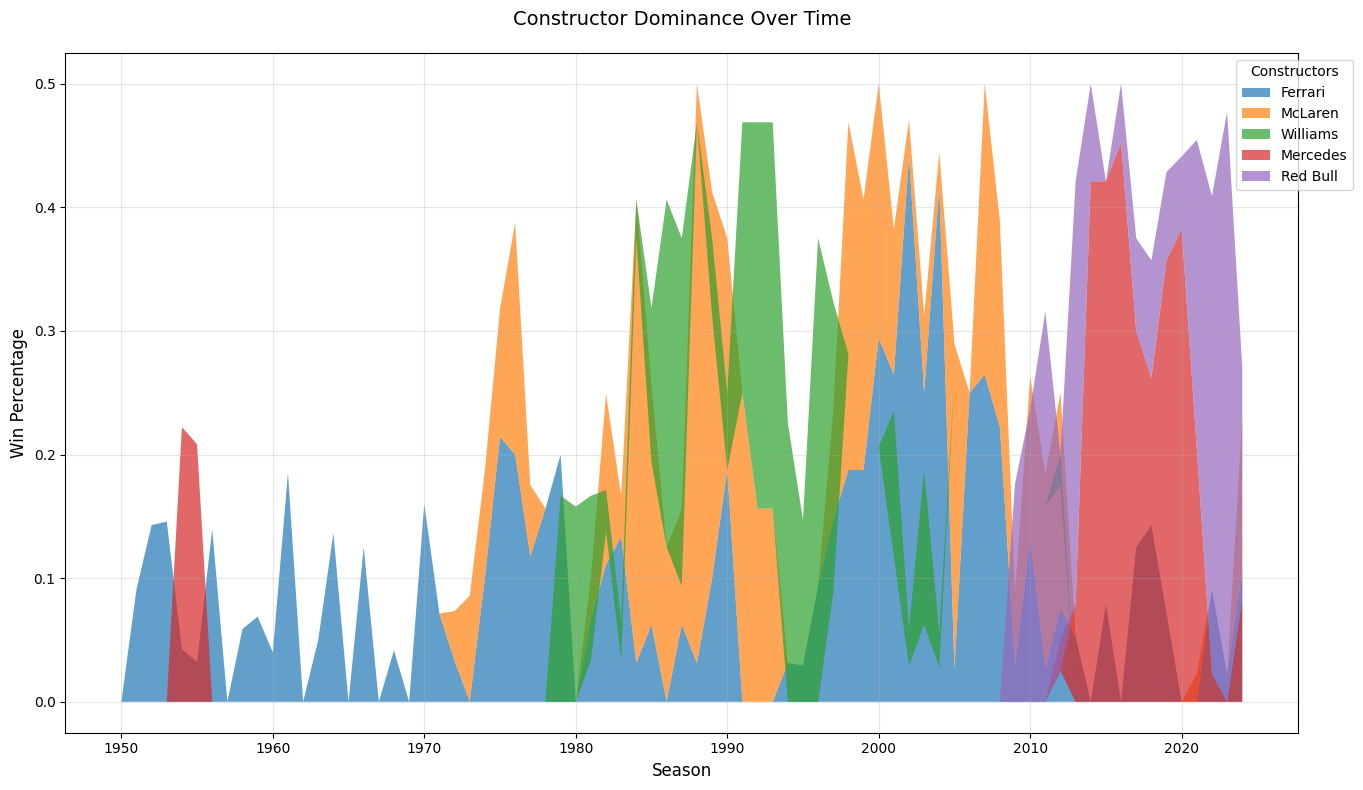

In [25]:
# Create timeline of constructor dominance
plt.figure(figsize=(15, 8))

# Calculate yearly win percentages
yearly_wins = data_df.pivot_table(
    index='season',
    columns='constructorName',
    values='driverFinalRank',
    aggfunc=lambda x: (x == 1).sum() / len(x)
).fillna(0)

# Plot stacked area chart for top constructors
top_constructors = yearly_wins.mean().nlargest(5).index
data_to_plot = [yearly_wins[constructor].values for constructor in top_constructors]

plt.fill_between(yearly_wins.index, data_to_plot[0], label=top_constructors[0], alpha=0.7)
for i in range(1, len(data_to_plot)):
    plt.fill_between(yearly_wins.index, 
                    data_to_plot[i-1] + data_to_plot[i], 
                    data_to_plot[i-1], 
                    label=top_constructors[i], 
                    alpha=0.7)

plt.title('Constructor Dominance Over Time', fontsize=14, pad=20)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Win Percentage', fontsize=12)
plt.legend(title='Constructors', bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\yeshw\AppData\Local\Temp\ipykernel_29984\1549725045.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  career_metrics['podiums'] = data_df.groupby('driverName').apply(


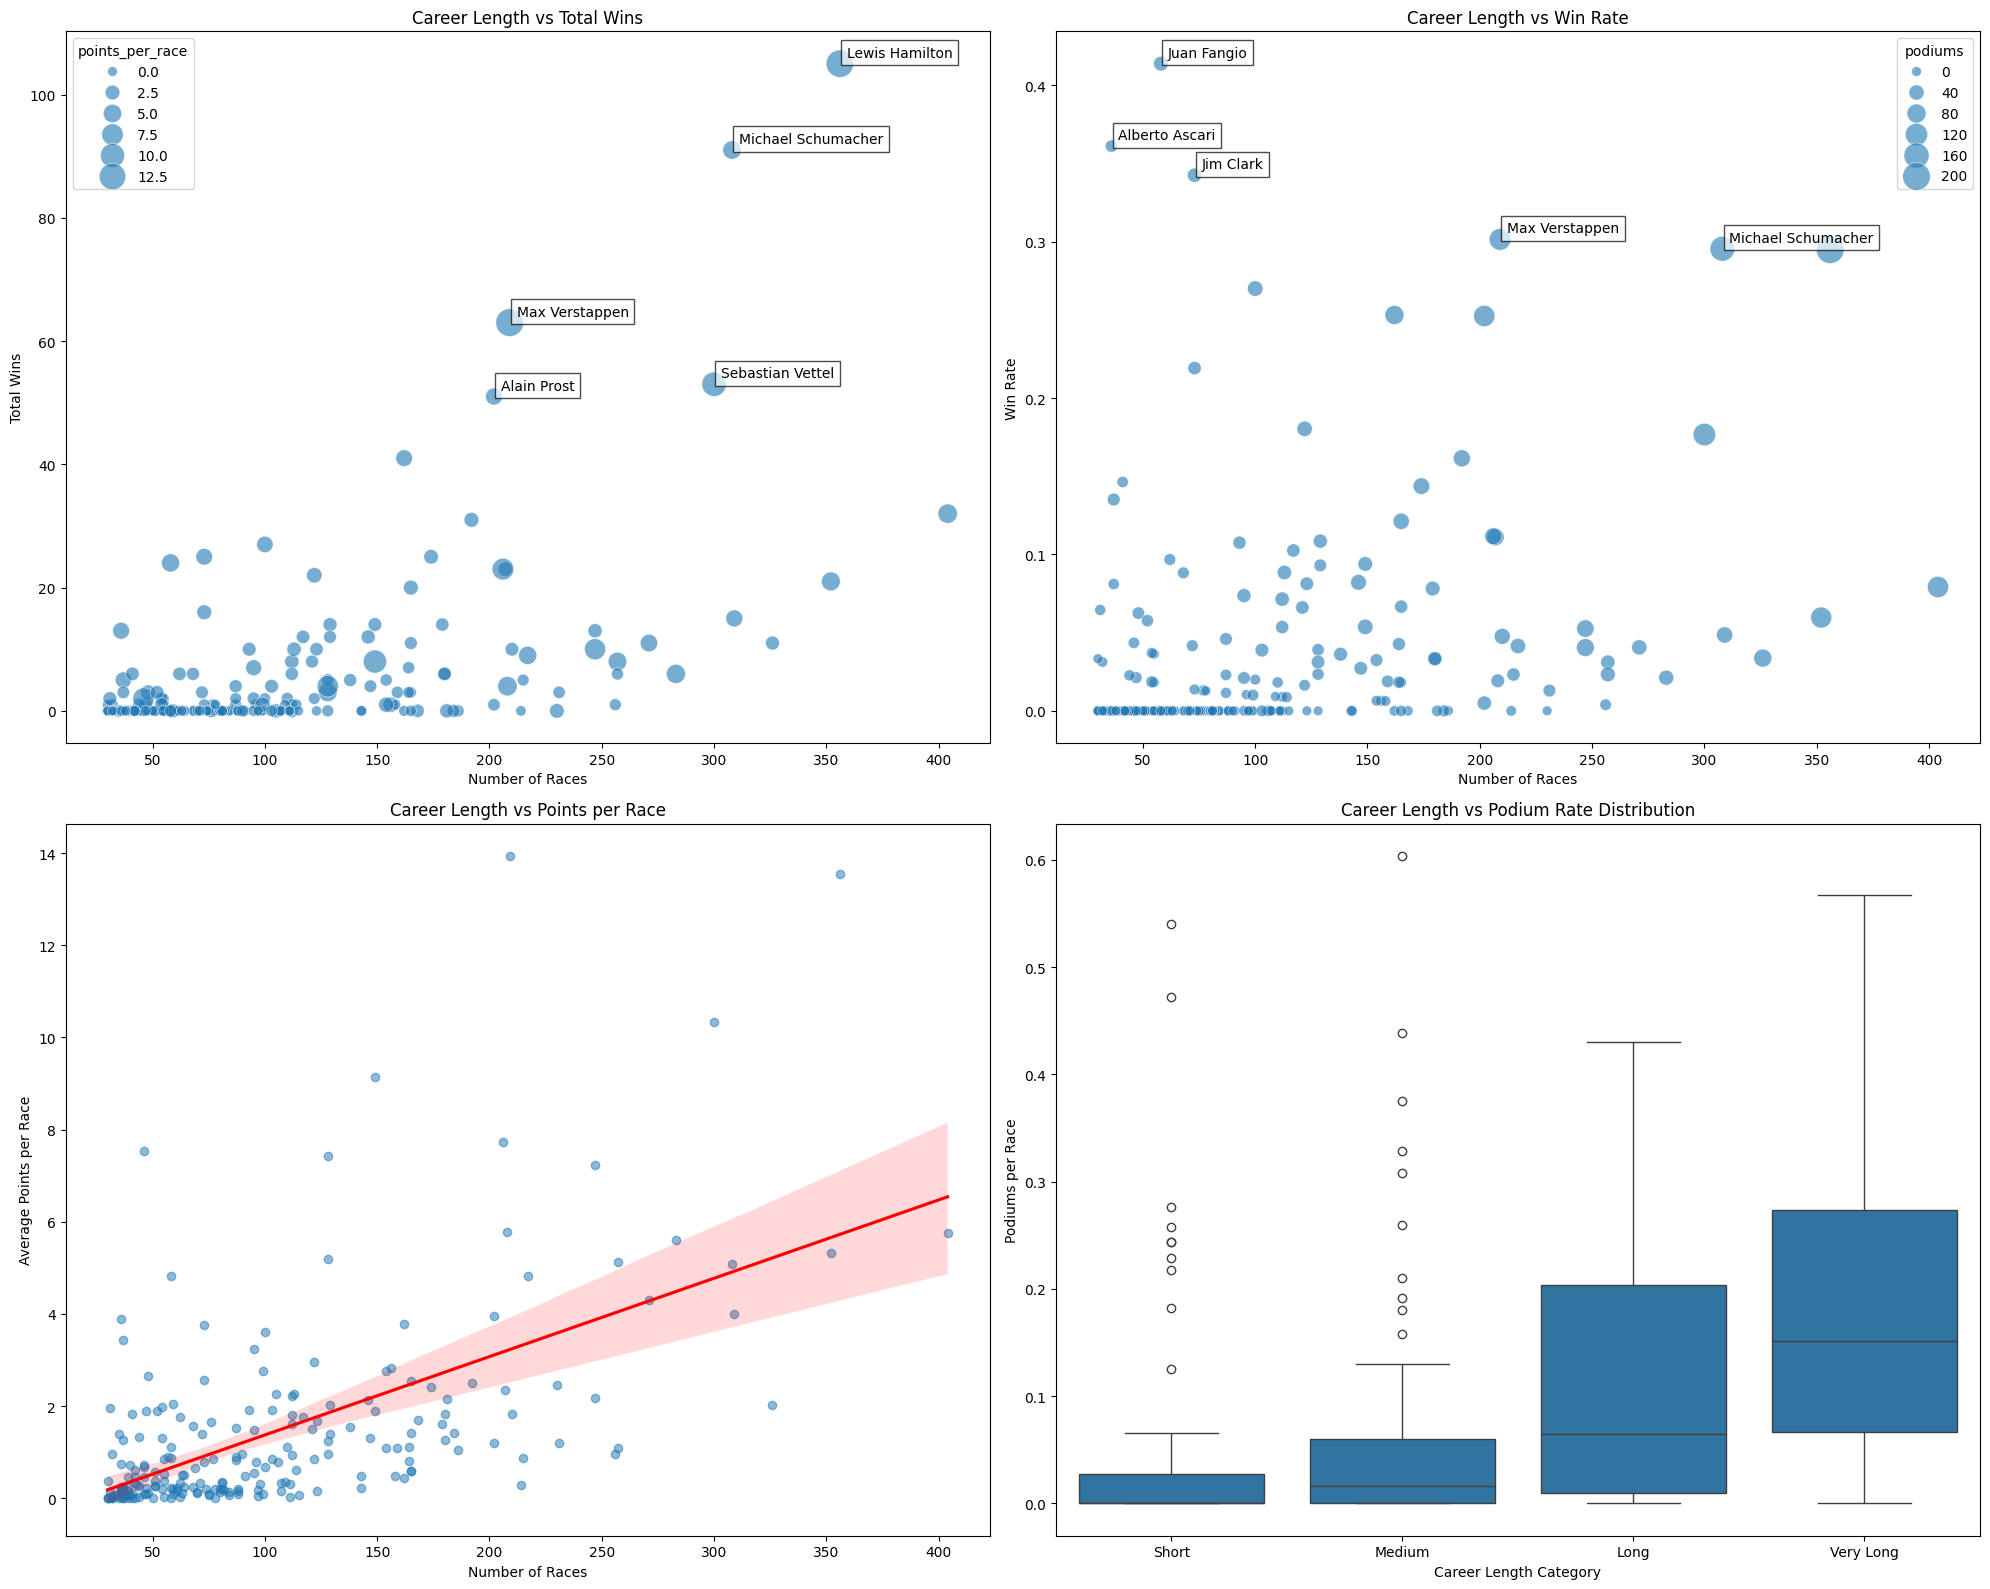


Career Length Analysis Summary:

Top 5 Drivers by Total Wins:
        driverName  raceId  driverFinalRank  wins_per_race
    Lewis Hamilton     356              105          0.295
Michael Schumacher     308               91          0.295
    Max Verstappen     209               63          0.301
  Sebastian Vettel     300               53          0.177
       Alain Prost     202               51          0.252

Correlation Analysis:
                 raceId  driverFinalRank  podiums  points_per_race
raceId            1.000            0.564    0.743            0.588
driverFinalRank   0.564            1.000    0.931            0.727
podiums           0.743            0.931    1.000            0.791
points_per_race   0.588            0.727    0.791            1.000


In [35]:
# Calculate career metrics
career_metrics = data_df.groupby('driverName').agg({
    'raceId': 'count',  # Career length
    'driverFinalRank': lambda x: (x == 1).sum(),  # Wins
    'driverRacePoints': 'sum',  # Total points
}).reset_index()

# Add podium count
career_metrics['podiums'] = data_df.groupby('driverName').apply(
    lambda x: sum(x['driverFinalRank'].isin([1, 2, 3]))
).values

# Calculate success rates
career_metrics['wins_per_race'] = career_metrics['driverFinalRank'] / career_metrics['raceId']
career_metrics['podiums_per_race'] = career_metrics['podiums'] / career_metrics['raceId']
career_metrics['points_per_race'] = career_metrics['driverRacePoints'] / career_metrics['raceId']

# Filter for drivers with minimum 30 races
career_metrics = career_metrics[career_metrics['raceId'] >= 30]

# Create subplot figure
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Scatter plot: Races vs Total Wins
ax1 = axes[0, 0]
sns.scatterplot(data=career_metrics, 
                x='raceId', 
                y='driverFinalRank',
                size='points_per_race',
                sizes=(50, 400),
                alpha=0.6,
                ax=ax1)

# Annotate top performers
top_winners = career_metrics.nlargest(5, 'driverFinalRank')
for _, row in top_winners.iterrows():
    ax1.annotate(row['driverName'],
                (row['raceId'], row['driverFinalRank']),
                xytext=(5, 5),
                textcoords='offset points',
                bbox=dict(facecolor='white', alpha=0.7))

ax1.set_title('Career Length vs Total Wins')
ax1.set_xlabel('Number of Races')
ax1.set_ylabel('Total Wins')

# 2. Scatter plot: Races vs Win Rate
ax2 = axes[0, 1]
sns.scatterplot(data=career_metrics, 
                x='raceId', 
                y='wins_per_race',
                size='podiums',
                sizes=(50, 400),
                alpha=0.6,
                ax=ax2)

# Annotate top win rates
top_rates = career_metrics.nlargest(5, 'wins_per_race')
for _, row in top_rates.iterrows():
    ax2.annotate(row['driverName'],
                (row['raceId'], row['wins_per_race']),
                xytext=(5, 5),
                textcoords='offset points',
                bbox=dict(facecolor='white', alpha=0.7))

ax2.set_title('Career Length vs Win Rate')
ax2.set_xlabel('Number of Races')
ax2.set_ylabel('Win Rate')

# 3. Points Evolution
ax3 = axes[1, 0]
sns.regplot(data=career_metrics,
            x='raceId',
            y='points_per_race',
            scatter_kws={'alpha':0.5},
            line_kws={'color': 'red'},
            ax=ax3)

ax3.set_title('Career Length vs Points per Race')
ax3.set_xlabel('Number of Races')
ax3.set_ylabel('Average Points per Race')

# 4. Success Metrics Distribution
ax4 = axes[1, 1]
career_metrics['career_length'] = pd.qcut(career_metrics['raceId'], 
                                        q=4, 
                                        labels=['Short', 'Medium', 'Long', 'Very Long'])

sns.boxplot(data=career_metrics,
            x='career_length',
            y='podiums_per_race',
            ax=ax4)

ax4.set_title('Career Length vs Podium Rate Distribution')
ax4.set_xlabel('Career Length Category')
ax4.set_ylabel('Podiums per Race')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nCareer Length Analysis Summary:")
print("\nTop 5 Drivers by Total Wins:")
print(top_winners[['driverName', 'raceId', 'driverFinalRank', 'wins_per_race']]
      .round(3).to_string(index=False))

print("\nCorrelation Analysis:")
correlations = career_metrics[['raceId', 'driverFinalRank', 'podiums', 'points_per_race']].corr()
print(correlations.round(3))